In [12]:
%matplotlib inline

import math
import warnings
import numpy as np
np.random.seed(7)

# specify to ignore warning messages
warnings.filterwarnings("ignore")

import keras
import sys
sys.path.insert(1,'E:\DUY\DS\deeplearning\PROJECTS\Custom_Tools')
import lstm_tools as lstmt

from sklearn.metrics import mean_squared_error


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('talk')

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)



In [14]:
window = 6
pred_length = int(window/2)
stock_index = 'b'

## Get data

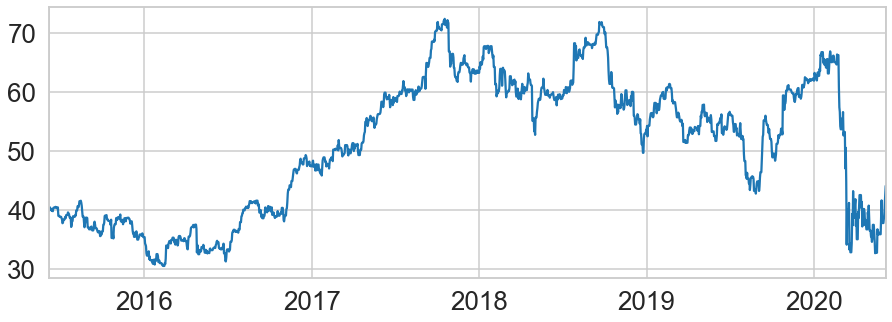

In [15]:
sp_df = lstmt.get_raw_data(stock_index)
sp_close_series = sp_df.Close

sp_close_series.plot()

In [16]:
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2015-06-08 to 2020-06-05
Freq: D
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1825 non-null   float64
 1   Low        1825 non-null   float64
 2   Open       1825 non-null   float64
 3   Close      1825 non-null   float64
 4   Volume     1825 non-null   float64
 5   Adj Close  1825 non-null   float64
dtypes: float64(6)
memory usage: 99.8 KB


## Preprocessing data

In [17]:
x_train,y_train,x_test,y_test,scaler = lstmt.get_reg_train_test(sp_close_series,
                                                                sequence_length=window+1,
                                                                roll_mean_window=None,
                                                                normalize=True,scale=False)

print("Data Split Complete")

print("x_train shape={}".format(x_train.shape))
print("y_train shape={}".format(y_train.shape))
print("x_test shape={}".format(x_test.shape))
print("y_test shape={}".format(y_test.shape))

Data Split Complete
x_train shape=(1636, 6, 1)
y_train shape=(1636,)
x_test shape=(182, 6, 1)
y_test shape=(182,)


## Prepare LSTM-Regression Model

In [18]:
lstm_model=None
try:
    lstm_model = lstmt.get_reg_model(layer_units=[50,100],window_size=window)
except:
    print("Model Build Failed. Trying Again")
    lstm_model = lstmt.get_reg_model(layer_units=[50,100],window_size=window)

> Compilation Time :  0.015956640243530273
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 6, 50)             10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 50)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_______

## Fit the Model

In [19]:
# use eatrly stopping to avoid overfitting
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=2,
                                           verbose=0)]
lstm_model.fit(x_train, y_train,
               epochs=20, batch_size=16,
               verbose=1,validation_split=0.05,
               callbacks=callbacks)
print("Model Fit Complete")

Train on 1554 samples, validate on 82 samples
Epoch 1/20
1554/1554 [==============================] - 1s 624us/step - loss: 6.5589e-04 - val_loss: 7.9244e-04
Epoch 2/20
1554/1554 [==============================] - 0s 289us/step - loss: 3.7641e-04 - val_loss: 4.2099e-04

## Train Prediction Performance

In [20]:
train_pred_seqs = lstmt.predict_reg_multiple(lstm_model,x_train,window_size=window,prediction_len=pred_length)

train_offset = y_train.shape[0] - np.array(train_pred_seqs).flatten().shape[0]

train_rmse = math.sqrt(mean_squared_error(y_train[train_offset:],
                                          np.array(train_pred_seqs).\
                                          flatten()))
print('Train Score: %.2f RMSE' % (train_rmse))


Train Score: 0.04 RMSE


## Test Prediction Performance

In [21]:
test_pred_seqs = lstmt.predict_reg_multiple(lstm_model,x_test,window_size=window,prediction_len=pred_length)

test_offset = y_test.shape[0] - np.array(test_pred_seqs).flatten().shape[0]

test_rmse = math.sqrt(mean_squared_error(y_test[test_offset:],
                                          np.array(test_pred_seqs).\
                                          flatten()))
print('Test Score: %.2f RMSE' % (test_rmse))

Test Score: 0.13 RMSE


## Plot Test Prediction

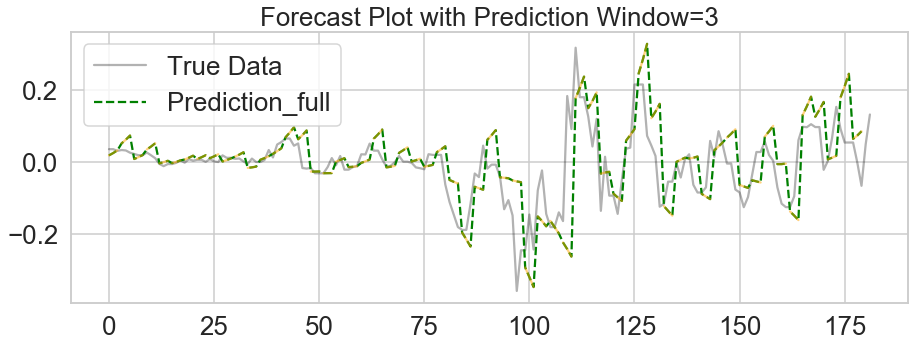

In [22]:
lstmt.plot_reg_results(test_pred_seqs,y_test,prediction_len=pred_length)